In [1]:
from google.colab import drive
import os
import pandas as pd

val_log_path = '/content/drive/MyDrive/RADAR_PAN_2025/Data/val_log.csv'
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = "cpu"

In [3]:
import json


train = []
with open('/content/drive/MyDrive/RADAR_PAN_2025/Data/train.jsonl', 'r') as f:
    for line in f:
        train.append(json.loads(line))


val = []
with open('/content/drive/MyDrive/RADAR_PAN_2025/Data/val.jsonl', 'r') as f:
    for line in f:
        val.append(json.loads(line))

human_train = []
ai_train = []
for i in range(len(train)):
  if train[i]['model'] == 'human':
    human_train.append(train[i]['text'])
  else:
    ai_train.append(train[i]['text'])

In [4]:
from torch.nn import functional as F
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from torch.optim import AdamW
from transformers import AutoTokenizer, AutoModelForCausalLM

detector_model = RobertaForSequenceClassification.from_pretrained('roberta-large', num_labels=2).to(device)
detector_tokenizer = RobertaTokenizer.from_pretrained('roberta-large')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [6]:
detector_model.load_state_dict(torch.load('/content/drive/MyDrive/detector_model.pth'))

<All keys matched successfully>

In [7]:
import random
def sample_validation_data(val_data, human_k=100, ai_k=200):
    human_samples = [ex for ex in val_data if ex['model'].lower() == 'human']
    ai_samples = [ex for ex in val_data if ex['model'].lower() != 'human']

    sampled = random.sample(human_samples, min(human_k, len(human_samples))) + \
              random.sample(ai_samples, min(ai_k, len(ai_samples)))

    random.shuffle(sampled)  # optional: shuffle the combined set
    return sampled

def evaluate_detector(samples, detector_model, detector_tokenizer):
    texts = [ex['text'] for ex in samples]
    labels = torch.tensor([ex['label'] for ex in samples], dtype=torch.long)
    with torch.no_grad():
      inputs = detector_tokenizer(texts, return_tensors='pt', padding=True, truncation=True).to(detector_model.device)
      logits = detector_model(**inputs).logits

      loss = F.cross_entropy(logits, labels.to(detector_model.device), reduction='mean').item()
      preds = torch.argmax(logits, dim=-1).cpu()

      accuracy = (preds == labels).float().mean().item()
    return loss, accuracy

In [8]:
import pandas as pd

val_subset = sample_validation_data(val)
val_loss, val_acc = evaluate_detector(val_subset, detector_model, detector_tokenizer)

In [9]:
df = pd.read_csv('/content/drive/MyDrive/RADAR_PAN_2025/Data/val_log.csv')

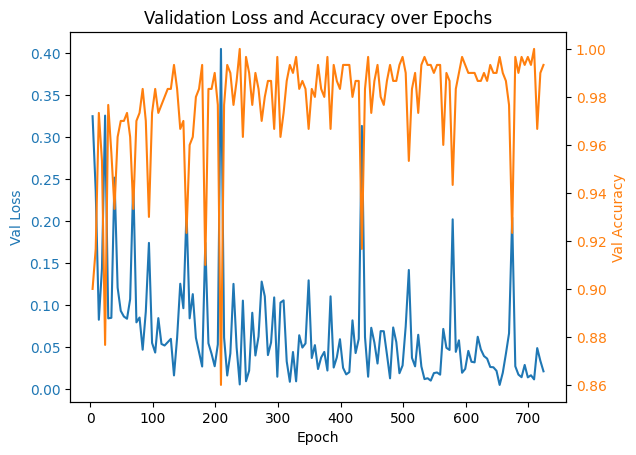

In [15]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()

# Plot val_loss on primary y-axis
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Val Loss', color='tab:blue')
ax1.plot(df['epoch'], df['val_loss'], color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create a second y-axis
ax2 = ax1.twinx()
ax2.set_ylabel('Val Accuracy', color='tab:orange')
ax2.plot(df['epoch'], df['val_accuracy'], color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')

plt.title("Validation Loss and Accuracy over Epochs")
plt.show()


In [16]:
val_subset

[{'id': 'a53de7c5-fc06-51d0-9300-7bedc83eb45b',
  'text': "As Mrs. Hebbard's anticipatory glance about the parlour room revealed an unbroken sheen of freshness, she was at once conscious of the probability of encountering some dissonance in its normally harmonious order. The very reflections that usually banished restlessness from her countenance took flight, leaving in its stead a singular perturbation. She had, it is not being facetious to say, thought she had anticipated every possible contingency as diligently as she had catalogued the particulars of her guest list, her decisions reaching the point of conviction that she had assembled an assemblage of persons singularly eligible to be exhibited advantageously before the social barons of the town. True, some disdainful utterances from the domestics had exhorted her against including the Clarks, on the grounds that they were not quite of the highest standing, but she had stood resolute against their urgings, persuaded that there lay 

In [17]:
labels = torch.tensor([ex['label'] for ex in val_subset], dtype=torch.long)
texts = [ex['text'] for ex in val_subset]



In [27]:
inputs = detector_tokenizer(texts[0], return_tensors='pt', padding=True, truncation=True).to(detector_model.device)
logits = detector_model(**inputs).logits

loss = F.cross_entropy(logits[0], labels[0].to(detector_model.device), reduction='mean').item()
preds = torch.argmax(logits, dim=-1).cpu()

IndexError: index 1 is out of bounds for dimension 0 with size 1

In [23]:
labels[0]

tensor(1)

In [26]:
loss

0.40452292561531067

In [30]:
logits[0]

tensor([-0.3237,  0.3723], device='cuda:0', grad_fn=<SelectBackward0>)